<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Обзор-данных" data-toc-modified-id="Обзор-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Обзор данных</a></span></li><li><span><a href="#Выбор-сплита,-моделей,-метрик-оценки" data-toc-modified-id="Выбор-сплита,-моделей,-метрик-оценки-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Выбор сплита, моделей, метрик оценки</a></span></li><li><span><a href="#Модель-прогнозирования-оттока" data-toc-modified-id="Модель-прогнозирования-оттока-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Модель прогнозирования оттока</a></span></li><li><span><a href="#Модель-кластеризации-пользователей" data-toc-modified-id="Модель-кластеризации-пользователей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Модель кластеризации пользователей</a></span></li><li><span><a href="#Выводы-и-рекомендации" data-toc-modified-id="Выводы-и-рекомендации-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы и рекомендации</a></span></li></ul></div>

# Повышение качества работы с клиентами на основе ML

К нам обратилась сеть фитнес-центров с вопросом исследования оттока клиентов из их сети. В их сети считается, что клиент "отвалился", если за последний месяц ни разу не посетил спортзал. Необходимо провести анализ и дать рекомендации по удержанию клиентов.

Для проведения анализа отдел по работе с клиентами фитнес-центров предоставил данные о клиентских анкетах. Ниже их описание (файл `gym_churn.csv`).  
**Описание данных в таблице:**
1. Данные клиента за предыдущий до проверки факта оттока месяц:
    - `gender` — пол;
    - `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
    - `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента);
    - `Promo_Friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
    - `Phone` — наличие контактного телефона;
    - `Age` — возраст;
    - `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).
2. Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
    - `Contract_period` — длительность текущего действующего абонемента (месяц, 6 месяцев, год);
    - `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
    - `Group_visits` — факт посещения групповых занятий;
    - `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
    - `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
    - 'Avg_additional_charges_total' — суммарная выручка от других услуг фитнес-центра: кафе, спорттовары, косметический и массажный салон.
3. `Churn` - факт оттока в текущем месяце.

**Цель исследования:** повышение прибыльности сети фитнес-центров за счет повышения качества работы с "утекающими" клиентами. Можно разбить на подзадачи:
1. Научиться прогнозировать вероятность оттока (на уровне следующего месяца) для каждого клиента.
2. Сформировать типичные портреты клиентов: выделить несколько наиболее ярких групп и охарактеризовать их основные свойства.
3. Выделить признаки, наиболее влияющие на отток, и разработать рекомендации по работе с клиентами.

**Ход исследования:**
1. Обзор данных (определение признаков и их типов, оценка пропусков, выбросов, распределения признаков). Цели обзора: определение ценных для моделей признаков, оценка полезности применения ML для решения задачи.
2. Предобработка данных: работа с пропусками, выбросами, категориальными признаками, стандартизация данных для моделей при необходимости.
3. Выбор сплита, моделей и метрик их оценки для поставленной задачи.
4. Построить модели прогнозирования оттока (на уровне следующего месяца) для каждого клиента и оценить модели по выбранным метрикам. 
5. Построить модель кластеризации клиентов, определить кластеры, подверженные оттоку.
6. Сформулировать основные выводы и разработать рекомендации по повышению качества работы с клиентами:
    - выделить целевые группы клиентов;
    - предложить меры по снижению оттока;
    - определить другие особенности взаимодействия с клиентами.




## Обзор данных

In [1]:
# Импортируем используемые библиотеки
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
                    accuracy_score, precision_score, 
                    recall_score, silhouette_score, f1_score
                    )
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import KMeans

In [2]:
# Открываем датасеты. Для двух версий работы с проектом 
# - две версии открытия сетов.

# Создаем локальный путь.
path_local = ''

# Создаем удаленный путь.
path_remote = '/datasets/'

# Добавляем имя файла.
filename = 'gym_churn.csv'

# Проверяя наличие путей к файлу, открываем датасет.
if os.path.exists(path_local + filename):
    gym = pd.read_csv(path_local + filename)
elif os.path.exists(path_remote + filename):
    gym = pd.read_csv(path_remote + filename)
else:
    print('Someting wrong')

In [3]:
# Пройдемся по фрейму и выведем общую информацию
temp = gym.copy() 
display(temp.info(), temp.head(), temp.tail(), temp.describe())
for col_l in temp.columns:
    print('-'* 80)
    print(col_l,': кол-во NaN',temp[col_l].isna().sum(),
        ', процент NaN', round(temp[col_l].isna().sum()/len(temp)*100, 2),'%')
print('-'* 80)
print('Кол-во дубликатов',temp.duplicated().sum(),
    ', процент дубликатов', round(temp.duplicated().sum()/len(temp)*100, 2),'%')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   float

None

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
3995,1,1,1,0,1,12,0,33,2.406023,12.0,8,2.284497,2.349070,0
3996,0,1,0,0,1,1,1,29,68.883764,1.0,1,1.277168,0.292859,1
3997,1,1,1,1,1,12,0,28,78.250542,11.0,2,2.786146,2.831439,0
3998,0,1,1,1,1,6,0,32,61.912657,5.0,3,1.630108,1.596237,0
3999,1,0,1,0,0,12,1,30,178.861814,12.0,1,1.101832,1.035270,0


,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
count,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000
mean,0.510250,0.845250,0.486750,0.308500,0.903500,4.681250,0.412250,29.184250,146.943728,4.322750,3.724750,1.879020,1.767052,0.265250
std,0.499957,0.361711,0.499887,0.461932,0.295313,4.549706,0.492301,3.258367,96.355602,4.191297,3.749267,0.972245,1.052906,0.441521
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,18.000000,0.148205,1.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,27.000000,68.868830,1.000000,1.000000,1.180875,0.963003,0.000000
50%,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,0.000000,29.000000,136.220159,1.000000,3.000000,1.832768,1.719574,0.000000
75%,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,1.000000,31.000000,210.949625,6.000000,5.000000,2.536078,2.510336,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,12.000000,1.000000,41.000000,552.590740,12.000000,31.000000,6.023668,6.146783,1.000000


--------------------------------------------------------------------------------
gender : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------------------------------------
Near_Location : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------------------------------------
Partner : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------------------------------------
Promo_friends : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------------------------------------
Phone : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------------------------------------
Contract_period : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------------------------------------
Group_visits : кол-во NaN 0 , процент NaN 0.0 %
--------------------------------------------------------------------------------
Age : кол-во NaN 0 , процент 

По предварительному обзору данных можно заметить, что:
1. Размер предоставленного датасета: 4000 строк и 14 столбцов. Таких данных должно быть достаточно, чтобы обучить довольно точную модель.
2. Данные полные, пропуски отсутствуют.
3. Названия колонок недостаточно удобны для работы, приведем все к нижнему регистру. 
4. Целевая переменная для машинного обучения прогноза оттока - `churn`, бинарна. Все остальные колонки - признаки, причем все выражены числом, однако, среди них есть категориальные признаки:
    - `gender`;
    - `Near_Location`;
    - `Partner`;
    - `Promo_friends`;
    - `Phone`;
    - `Contract_period`;
    - `Group_visits`.
5. Данных о временном распределении нет, временные метки отсутствуют.
6. В представленном датасете чуть более 26% - данные об "утекших" клиентах.

Посмотрим на средние значения внутри "утекшей" группы и "оставшейся".



In [4]:
# Приводим названия столбцов к нижнему регистру
gym.columns = gym.columns.str.lower()

# Группируем и считаем среднее каждого признака
gym.groupby('churn').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month
churn,,,,,,,,,,,,,
0,0.510037,0.873086,0.534195,0.353522,0.903709,5.747193,0.464103,29.976523,158.445715,5.283089,4.711807,2.024876,2.027882
1,0.510839,0.768143,0.355325,0.183789,0.902922,1.728558,0.268615,26.989632,115.082899,1.662582,0.990575,1.474995,1.044546


Из средних показателей двух групп, можно знаметить, например, что "утекшие" клиенты моложе, реже ходили на групповые занятия, а самое главное - их абонемент итак подходил к концу.  

Посмотрим на данные подробнее. Построим следующие графики, чтобы попытаться предположить гипотезы о зависимостях в данных:
1. Гистограммы распределения переменных для определения выбросов в разрезе churn. Реализуем построение через histplot с функцией сглаживания, отделив категориальные от количественных признаков.
2. Матрицу корреляции всех переменных и тепловую карту по корреляции.


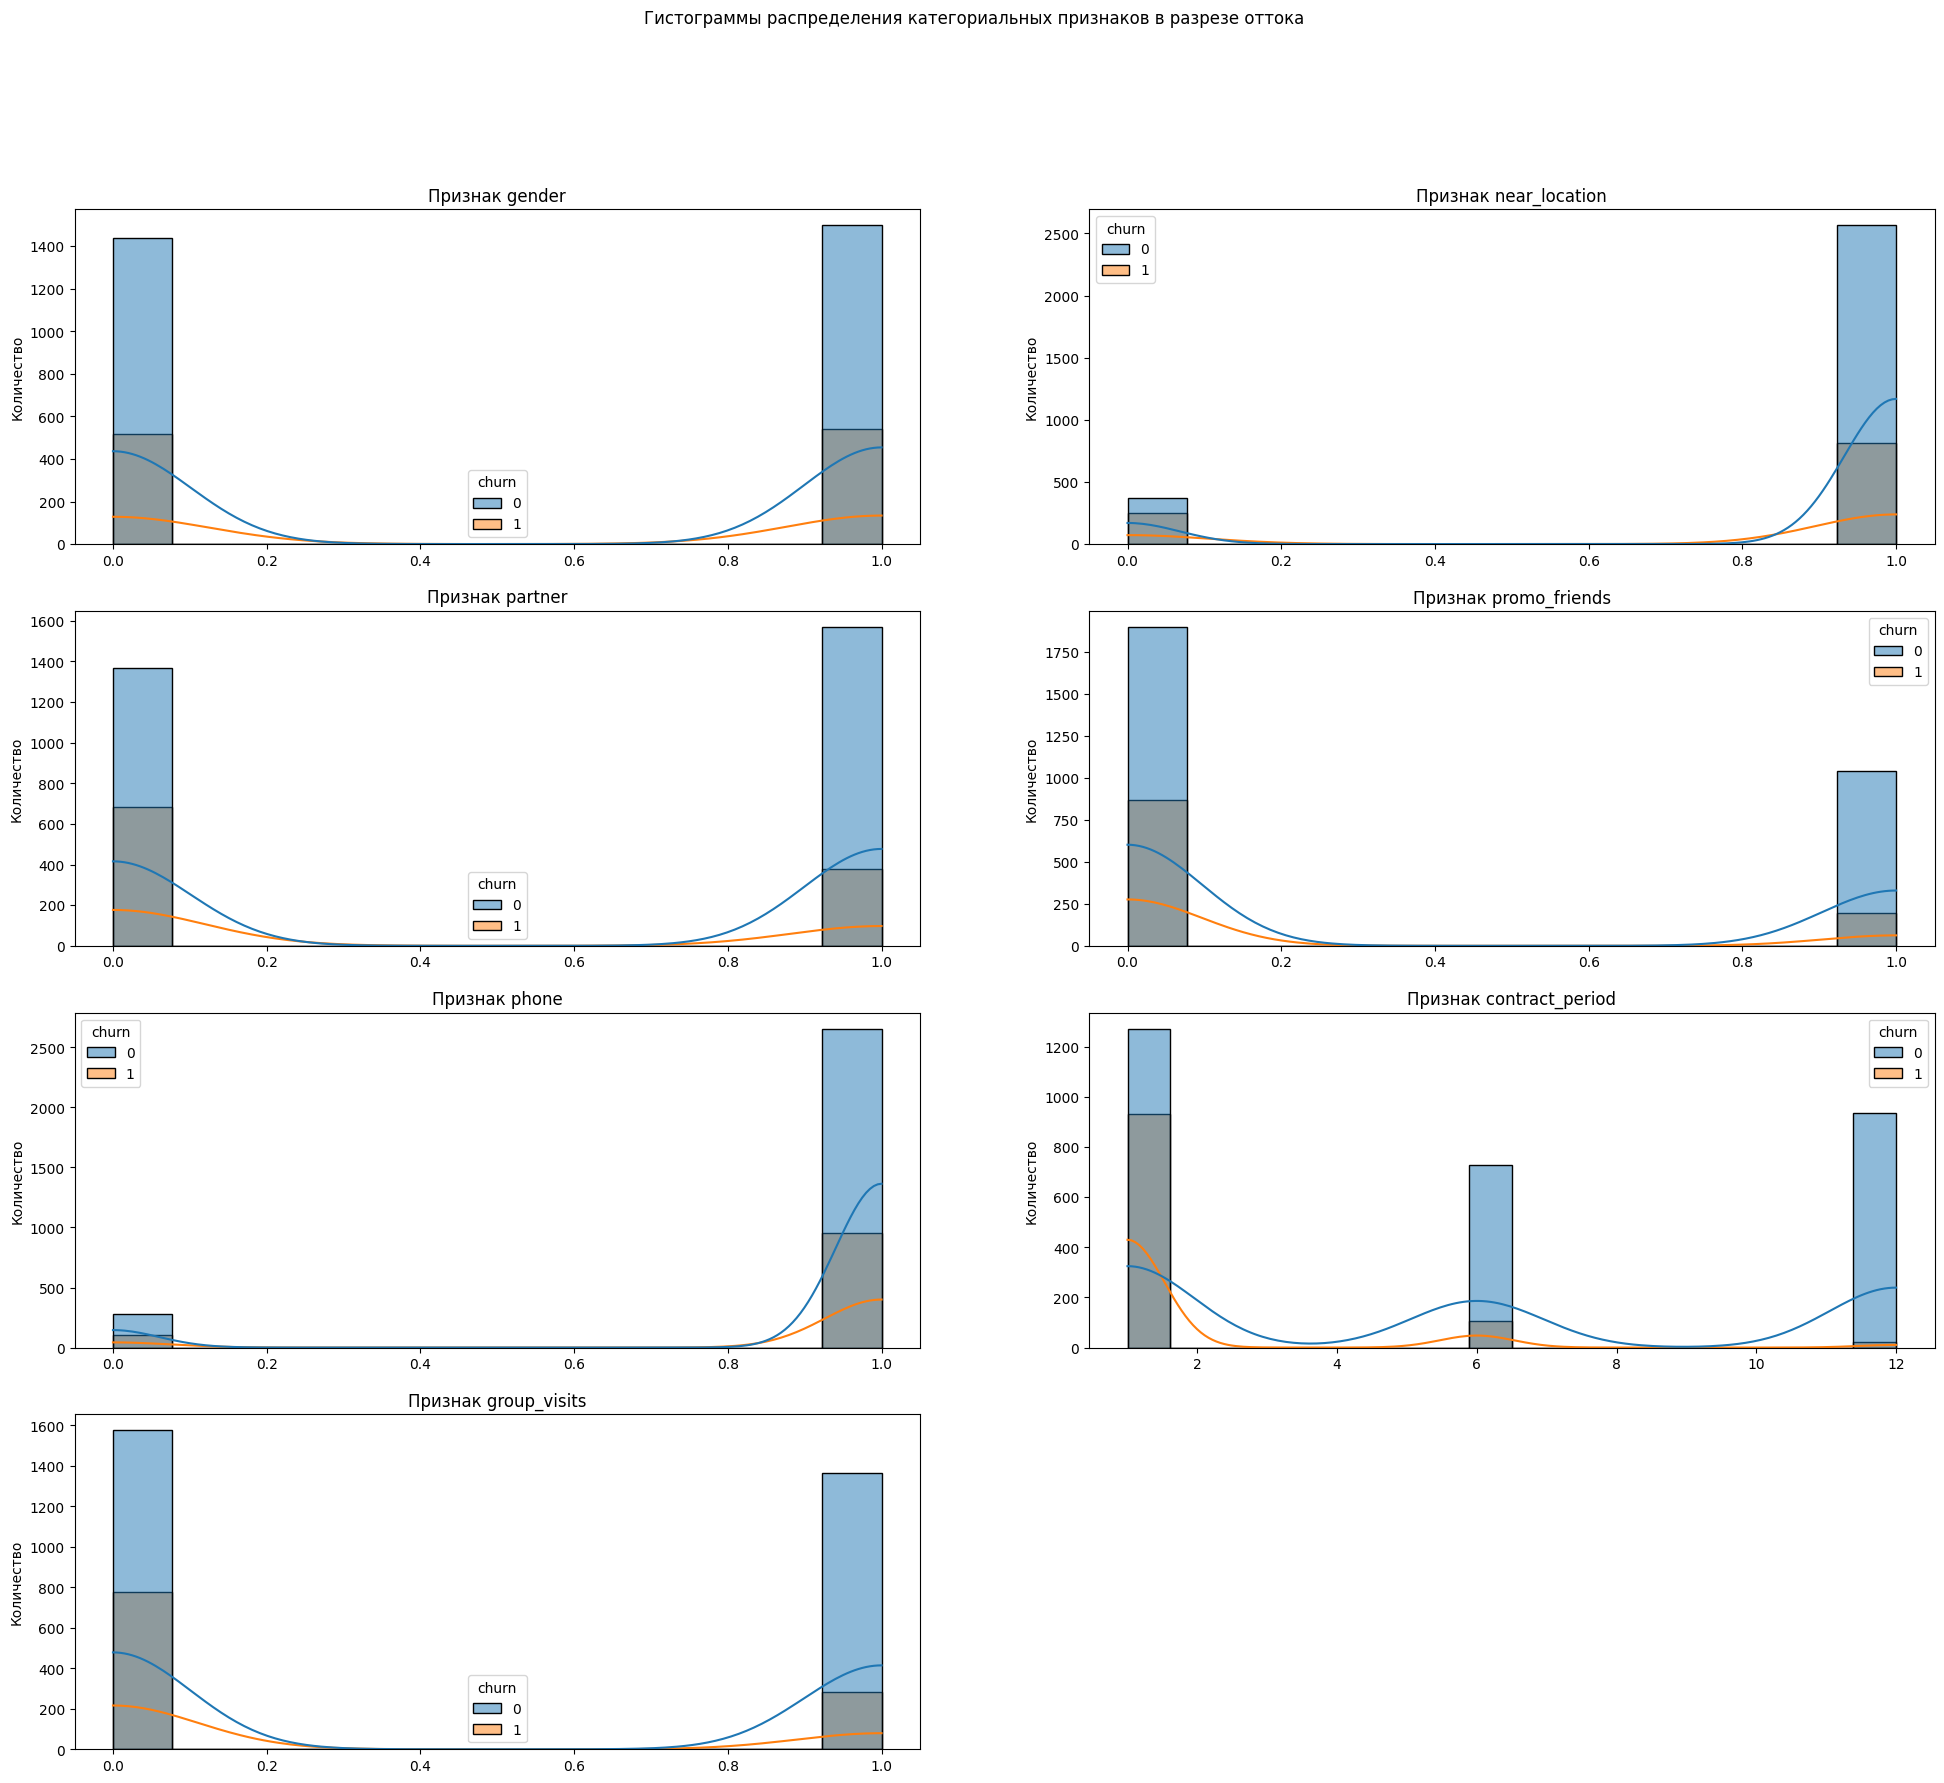

In [5]:
# Строим гистограммы для категориальных признаков в разрезе churn
# Делаем временный фрейм для графика
temp = pd.concat([gym.iloc[:, :7], gym['churn']], axis = 1)

# Задаем размер всего графика и общее название
fig = plt.figure(figsize=(24,20))

# Отрисовываем распределения в новых сабплотах
for index, name in enumerate(gym.iloc[:, :7]):
    ax = fig.add_subplot(4, 2, index+1)
    sns.histplot(data=temp, kde=True, x=name, hue='churn', ax=ax).set(title='Признак '+name, xlabel='', ylabel='Количество')
# Задаем общее название
fig.suptitle('Гистограммы распределения категориальных признаков в разрезе оттока')
plt.show()

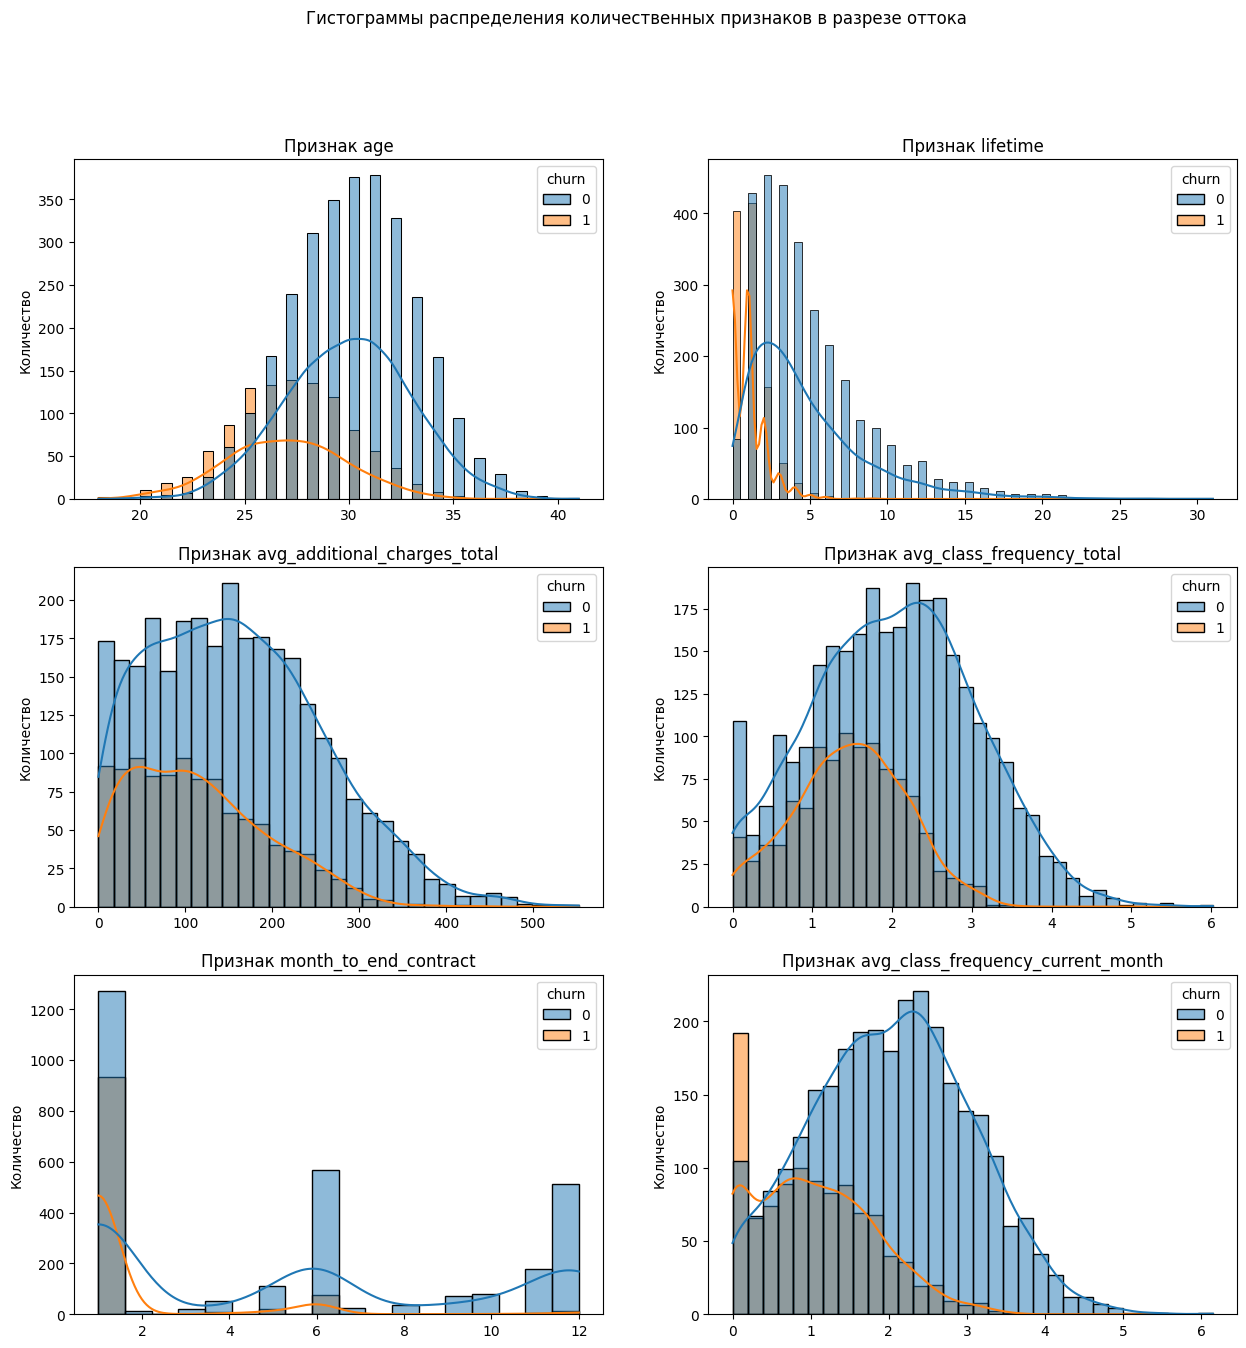

In [6]:
# Строим гистограммы для количественных признаков в разрезе churn
# Задаем сабплоты
fig, axs = plt.subplots(3, 2, figsize=(15,15))

# Отрисовываем распределения
for index, name in enumerate(gym.iloc[:, 7:].drop(columns='churn')):
    sns.histplot(data=gym.iloc[:, 7:], kde=True, x=name, hue='churn', ax=axs[index%3, index//3]).set(title='Признак '+name, xlabel='', ylabel='Количество')

# Задаем общее название
fig.suptitle('Гистограммы распределения количественных признаков в разрезе оттока')
plt.show()

По построенным гистограммам и попарным диаграммам рассеяния признаков в разрезе оттока можно сделать следующие выводы:
1. Распределение всех количественных признаков нормальное.
2. По гистограммам все данные выглядят нормально, без бросающихся в глаза выбросов.
3. Клиенты, первый раз обратившиеся в этом или предыдущем месяце, уходят больше остальных (приобрели абонемент, попробовали, и не остались). Возможно, в сети действует программа "первый месяц бесплатно" - тогда такое поведение объяснить еще легче: люди ходят бесплатно месяц, а платить не хотят.
4. Также уходит много клиентов, не уделяющие достаточного внимания групповым занятиям.

Постоим матрицу корреляции и посмотрим на тепловую карту корреляции, возможно, присутствуют коррелирующие друг с другом признаки.

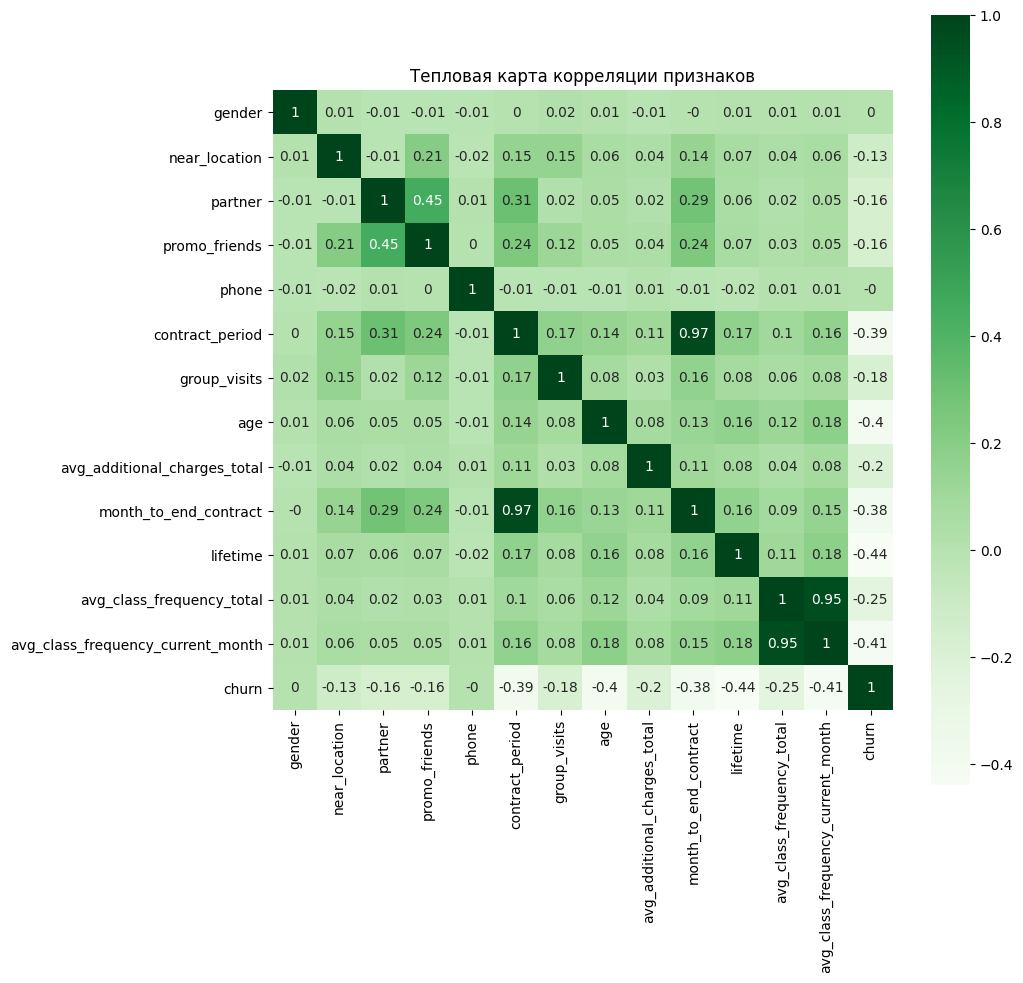

In [7]:
# Задаем матрицу корреляции
corr_matrix = gym.corr().apply(lambda x: round(x, 2))

# Рисуем тепловую карту
fig, ax = plt.subplots(figsize=(10,10))

sns.heatmap(corr_matrix, annot=True, square=True, cmap='Greens', ax=ax)
plt.title('Тепловая карта корреляции признаков')
plt.show()

Из тепловой карты видно, что есть две пары сильно коррелирующих друг с другом признаков:
- среднее количество посещений групповых занятий за весь период и за прошлый месяц;
- длительность текущего абонемента и количество месяцев до конца контракта.  

Что касается наиболее сильно влияющих на отток клиентов признаков, то среди них можно выделить все те же длительность абонемента и месяцы до его окончания, время с момента первого обращения в клуб, возраст и среднее количество групповых занятий за последний месяц. Все они имеют умеренную обратную корреляцию с оттоком клиентов.  
Что странно, несмотря на то, что среднее количество групповых за весь период и за прошлый месяц хорошо коррелируют друг с другом, на целевую переменную они влияют по-разному. Это еще один довод в копилку приведенной выше теории о первом бесплатном месяце в клубе.  

В целом, данные не очень изменчивы, по предоставленным данным можно построить удачную модель.

Т.к. в данных отсутствуют пропуски, выбросы, категориальные переменные, то предобработку данных для модели можно пропустить. Стандартизацию признаков выполним позднее, перед построениями моделей. Сейчас перейдем к выбору сплита, алгоритмов и метрик.

## Выбор сплита, моделей, метрик оценки

Как было замечено ранее, в данных отсутствуют временные метки. Следовательно, сплитить данные по времени не представляется возможным. Сплит будет случайным 80 на 20.

Прогнозирование оттока клиентов является задачей бинарной классификации, относящейся к обучению с учителем. Среди возможных алгоритмов можно использовать:
- логистическая регрессия;
- дерево принятия решения;
- случайный лес;
- градиентный бустинг.

В данном проекте остановимся на логистической регрессии как легко интерпретируемой модели, и на случайном лесу.

В качестве оценки метрик данных моделей выберем:
- доля правильных ответов (accuracy) - здесь необходимо помнить, что данная метрика работает только при балансе классов, а в нашем случае разделение 26 на 74;
- точность - доля правильных ответов среди целевого класса (precision);
- полнота - сколько реальных объектов целевого класса обнаружено (recall);
- f1, т.к. она учитывает баланс между точностью и полнотой.

При этом бизнесу важно обнаружить всех клиентов, которые могут уйти, и попытаться их удержать. Однако, удерживать всех может быть затратно (модель, когда все клиенты считаются уходящими). Таким образом, необходимо учитывать балланс метрик полнота и точность. Для учитывания баланса этих метрик выберем ключевой метрикой - f1. За baseline модель возьмем ту, которая всех клиентов считает уходящими, у такой модели f1 будет 41.
Также не следует забывать о том, что сплит целевого класса неровный, и, возможно, стоит изменить порог для моделей.

Что касается задачи кластеризации пользователей, то это задача обучения без учителя, и здесь возможно использование следующих алгоритмов:
- K-Means;
- Агломеративная кластеризация;
- DBSCAN.

В данном проекте остановимся на агломеративной кластеризации на случайной выборке для определения количества кластеров, а саму задачу кластеризации решим быстрым KMeans.

В качестве метрики оценки работы модели будем использовать метрику силуэта.

## Модель прогнозирования оттока

Так как модели семейства линейных регрессий неусточивы к взаимной корреляции признаков, удалим признаки "месяцы до конца договора" и "среднее число групповых занятий за все время", как менее коррелирующие с целевой переменной из своих мультиколлинеарных пар.

In [8]:
# Удаляем коррелирующие признаки
gym.drop(columns=['month_to_end_contract', 'avg_class_frequency_total'], inplace=True)
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0


In [9]:
# Делим выборку
X_train, X_test, y_train, y_test = train_test_split(gym.iloc[:, :11], 
                                                    gym.iloc[:, -1:], 
                                                    test_size=0.2, 
                                                    random_state=0)
# Тестовую выборку делим на валидирующую (для сравнения моделей)
# и тестовую (для проверки лучшей модели)
X_valid, X_test, y_valid, y_test =  train_test_split(X_test, 
                                                    y_test, 
                                                    test_size=0.5, 
                                                    random_state=0)

Теперь необходимо стандартизировать признаки.

In [10]:
# Стандартизируем
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc = scaler.transform(X_train)
X_valid_sc = scaler.transform(X_valid)
X_test_sc = scaler.transform(X_test)

Можно переходить к обучению моделей.

In [11]:
# Задаем функцию обучения моделей
def get_pred_probs(model, X_train, y_train, X_test):
    #model = model(random_state=0)
    model.fit(X_train_sc, y_train.values.ravel())
    predictions = model.predict(X_test_sc)
    probabilities = model.predict_proba(X_test_sc)[:, 1]
    return predictions, probabilities

# Задаем функцию вывода метрик моделей
def get_metrics(y_test, predictions, title):
    print('='*20 + title + '='*20)
    print('Accuracy: {:.2f}'.format(accuracy_score(y_test, predictions)))
    print('Precision: {:.2f}'.format(precision_score(y_test, predictions)))
    print('Recall: {:.2f}'.format(recall_score(y_test, predictions)))
    print('F1: {:.2f}'.format(f1_score(y_test, predictions)))

In [12]:
# Получаем прогнозы и вероятности для логистической регрессии
log_pred, probabilities_log = get_pred_probs(LogisticRegression(solver='liblinear', random_state=0), 
                                             X_train_sc, 
                                             y_train, 
                                             X_valid_sc)

# Получаем прогнозы и вероятности для случайного леса
forest_pred, probabilities_forest = get_pred_probs(RandomForestClassifier(), 
                                                   X_train_sc, 
                                                   y_train, 
                                                   X_valid_sc)

# Сравниванием метрики
get_metrics(y_valid, log_pred, 'Метрики логистической регрессии')
get_metrics(y_valid, forest_pred, 'Метрики случайного леса')

====================Метрики логистической регрессии====================
Accuracy: 0.63
Precision: 0.25
Recall: 0.29
F1: 0.27
====================Метрики случайного леса====================
Accuracy: 0.65
Precision: 0.26
Recall: 0.26
F1: 0.26


Попробуем улучшить f1 через задание порога вручную, т.к. распределение классов в представленной выборке было неровным.

In [13]:
# Задаем порог
threshold = 0.39

# На основании вероятностей и соотношения классов рассчитаем predict
custom_predictions_log = [0 if i < threshold else 1 for i in probabilities_log]
custom_predictions_forest = [0 if i < threshold else 1 for i in probabilities_forest]

# Сравниванием метрики
get_metrics(y_test, custom_predictions_log, 'Метрики логистической регрессии')
get_metrics(y_test, custom_predictions_forest, 'Метрики случайного леса')

====================Метрики логистической регрессии====================
Accuracy: 0.90
Precision: 0.77
Recall: 0.85
F1: 0.81
====================Метрики случайного леса====================
Accuracy: 0.88
Precision: 0.73
Recall: 0.83
F1: 0.77


С помощью ручного определения порога удалось значительно повысить обнаружение уходящих клиентов.  
В обоих случаях логистическая регрессия показала себя лучше, т.к. в обоих случаях она обнаруживает большее количество клиентов, которые собираются покинуть клуб. В таком случае можно использовать для них некоторые маркетинговые приемы, чтобы их удержать.  
Проверим лучшую модель на тестовой выборке, используя ручной порог.

In [14]:
# Получаем прогнозы и вероятности для тестовой выборки
log_pred, probabilities_log = get_pred_probs(LogisticRegression(solver='liblinear', random_state=0), 
                                             X_train_sc, 
                                             y_train, 
                                             X_test_sc)
# Задаем порог
threshold = 0.39

# На основании вероятностей и соотношения классов рассчитаем predict
custom_predictions_log = [0 if i < threshold else 1 for i in probabilities_log]

# Выводим метрики
get_metrics(y_test, custom_predictions_log, 'Метрики логистической регрессии')

====================Метрики логистической регрессии====================
Accuracy: 0.90
Precision: 0.77
Recall: 0.85
F1: 0.81


На тестовой выборке модель также показывает себя также хорошо. 

## Модель кластеризации пользователей

Для кластеризации оставим только признаки клиентов (без столбца `churn`). Затем стандартизируем их.

Для определения количества классов, на которое будем делить с помощью KMeans, нарисуем дендрограмму на уже стандартизированной подвыборке в 10% X_test_sс.

In [15]:
# Оставляем признаки
X = gym.iloc[:, :11]

# Стандартизируем
scaler.fit(X)
X_sc = scaler.transform(X)

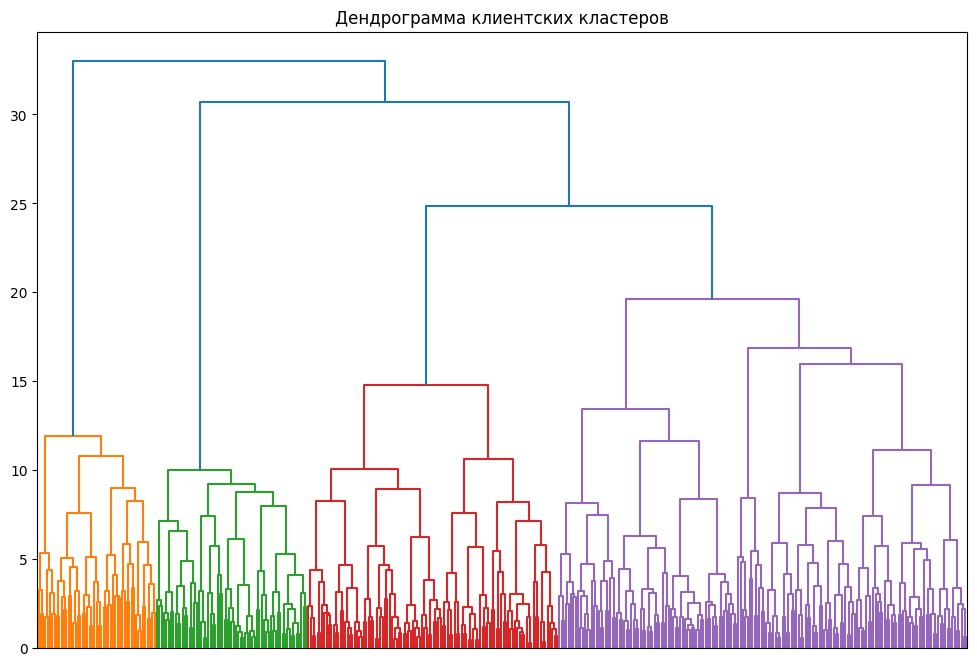

In [16]:
# Создаем связи на 10% выборке
linked = linkage(X_test_sc, method='ward')
# Визуализируем связи
plt.figure(figsize=(12,8))
dendrogram(linked, orientation='top', no_labels=True)
plt.title('Дендрограмма клиентских кластеров')
plt.show()

На дендрограмме можно выделить 5 кластеров (если фиолетовый разделить на два поменьше). Таким образом, будем строить модель для 5 кластеров.

In [17]:
# Делим на кластеры и сохраняем метки
cluster = KMeans(n_clusters=5, random_state=0)
labels = cluster.fit_predict(X_sc)

# Добавляем метки кластеров в датафрейм
gym['clusters'] = labels
gym.head()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn,clusters
0,1,1,1,1,0,6,1,29,14.227470,3,0.000000,0,4
1,0,1,0,0,1,12,1,31,113.202938,7,1.910244,0,3
2,0,1,1,0,1,1,0,28,129.448479,2,1.736502,0,2
3,0,1,1,1,1,12,1,33,62.669863,2,3.357215,0,0
4,1,1,1,1,1,1,0,26,198.362265,3,1.120078,0,0


Рассчитаем метрику силуета для получившейся модели.

In [18]:
print('Метрика силуэта:', silhouette_score(X_sc, labels))

Метрика силуэта: 0.13904733417201764


По данной метрике, этой модели еще далеко до идеала.  

Посмотрим на средние значения разных признаков для разных кластеров.

In [19]:
gym.groupby('clusters').mean()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
clusters,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


Из рассмотрения средних значений признаков в кластерах можно сделать следующие выводы:
1. По полу клиенты распределены равномерно во всех кластерах.
2. В кластер 0 попали только люди, которые живут или работают не рядом с клубом.
3. В кластере 0 почти все люди, у которых был промо от друга и по партнерской программе.
4. В кластере 4 все люди не указали номер телефона.
5. В кластерах 1 и 2 самые низкие показатели среднего срока окончания абонемента. В этих же группах самый низкий процент посещения групповых занятий - ниже 30.
6. В кластере 2 самые новенькие клиенты - в этом кластере самый низкий средний показатель количества месяцев с момента первого обращения в клуб.
7. Самый низкий показатель оттока в группах 3 и 0. В кластере 3 почти никто не уходит - отток 1,5%. Самые высокие оттоки в группе 2, затем 1. Группа 4 в середнечках.

Посмотрим на эти данные на графиках. Построим распределение признаков по кластерам.


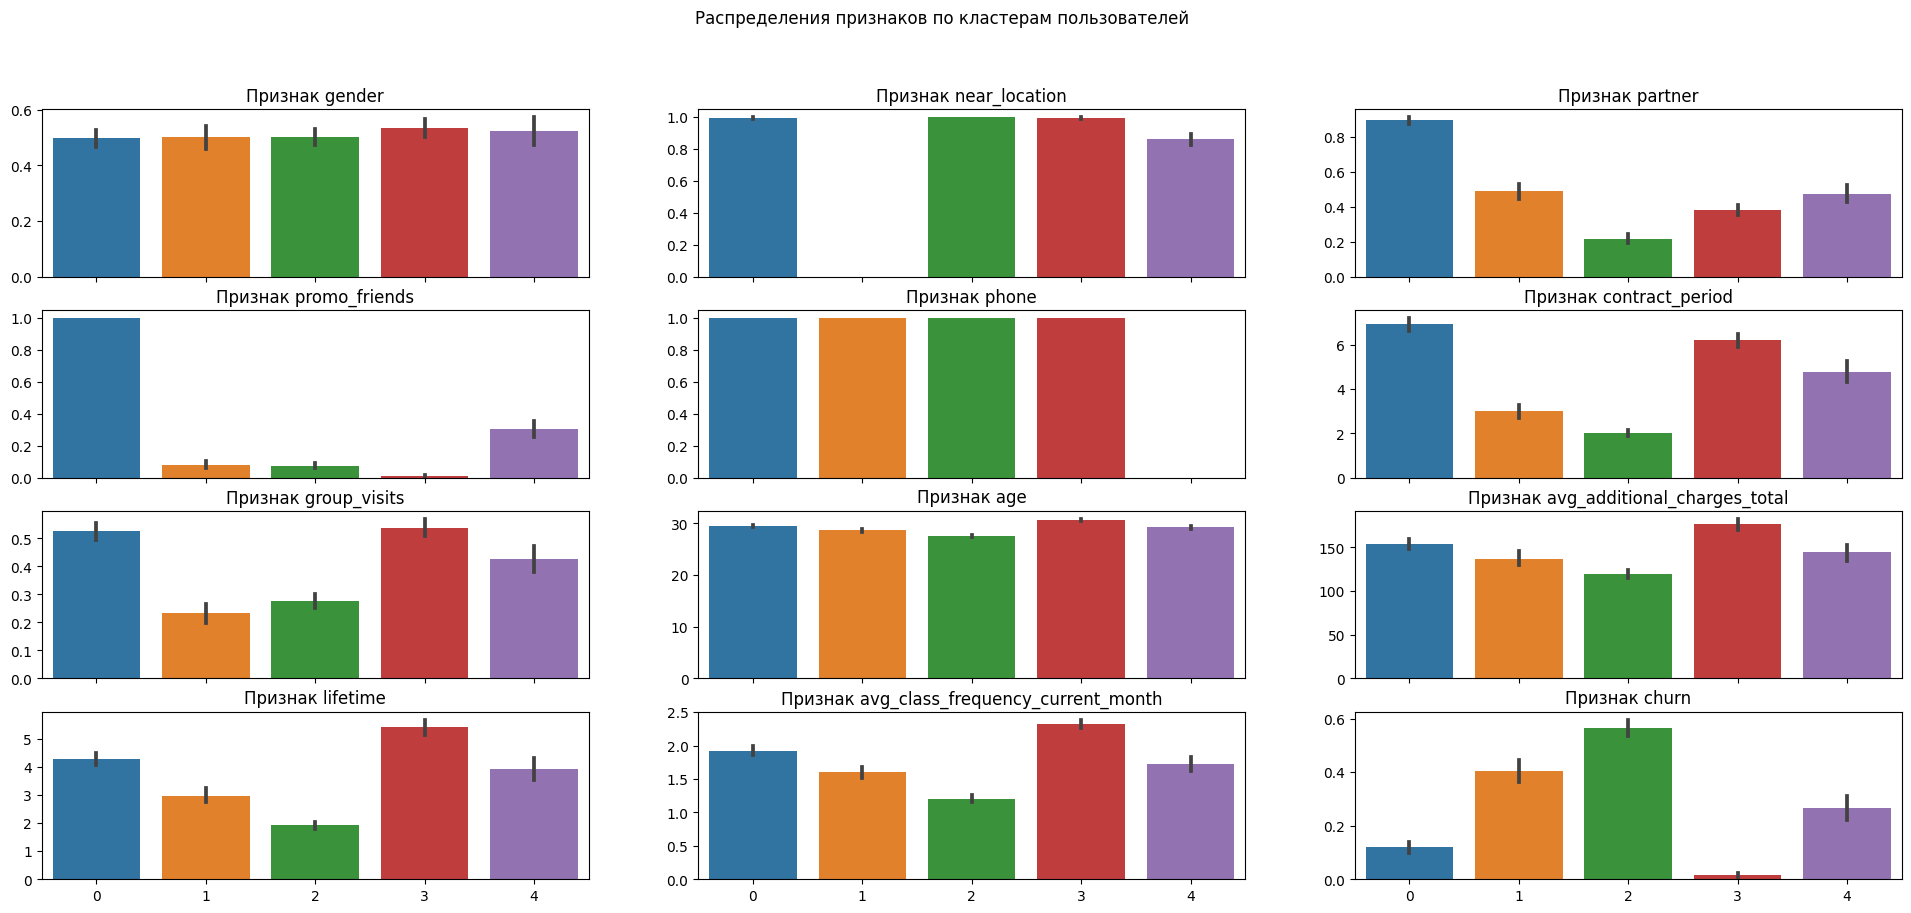

In [20]:
# Задаем сабплоты
fig, axs = plt.subplots(4, 3, figsize=(24,10), sharex='col')
fig.suptitle('Распределения признаков по кластерам пользователей')
# Отрисовываем распределения
for index, name in enumerate(gym.drop(columns='clusters').columns):
    sns.barplot(data=gym, x='clusters', y=name, ax=axs[index//3, index%3]).set(title='Признак '+name, xlabel='', ylabel='')

Рассмотрение признаков в разрезе кластеров подтвердили все выводы, сделанные по таблице средних значений этих признаков.

## Выводы и рекомендации 

Были проанализированы данные об оттоке клиентов сети фитнес-центров. Можно сделать следующие выводы:
1. Были обучены две модели, прогнозирующие отток пользователей в следующем месяце. Лучшей оказалась модель, основанная на логистической регрессии. Данную модель можно использовать для выявления пользователей, которые требуют особого внимания, чтобы они не уходили из сети.
2. Пользователи были кластеризованы на 5 кластеров с помощью модели, основанной на K-средних. Особое внимание к себе требуют 2 и 1 группы как группы с самым высоким оттоком. Выделяющимися признаками для этих групп являются:
- заканчивающееся действие абонемента;
- недавнее первичное посещение сети клубов;
- редкое посещение групповых занятий;
- исключительно для группы 1 - дальнее расположение работы и дома от клуба.
3. В связи с выделенными кластерами клиентов можно дать следующие рекомендации для удержания клиентов:
- отслеживание пользователей с оканчивающимся сроком действия абонемента. Предлагается за месяц до окончания абонемента напоминать об этом клиенту, возможно, предложив скидку на продление;
- было предположено, что отток клиентов, которые только недавно пришли первый раз, связан с акцией "первый месяц бесплатно". В таком случае возможно стоит отказаться от такой акции в пользу "платной" - 50% скидка для всех новичков;
- для борьбы с оттоками из-за редких посещений групп, предлагается бесплатно при покупке абонемента предлагать 10 любых групповых занятий;
- для заинтересованности людей, живущих и работающих далеко от клуба, рекомендуется предлагать скидку на такси и каршеринги при посещении любого клуба сети.